In [1]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
FAST_RUN = False
IMAGE_WIDTH = 244
IMAGE_HEIGHT = 244
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [3]:
filenames = os.listdir(r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\train\train5")

In [4]:
labels = []
for f in filenames:
    label = f.split(' ')[0]
    if label == 'good':
        labels.append(0)
    else:
        labels.append(1)
df = pd.DataFrame({'filename': filenames, 'label':labels})

In [5]:
df.head()

,filename,label
0,bad (1)k.jpeg,1
1,bad (10)k.jpeg,1
2,bad (100)k.jpeg,1
3,bad (101)k.jpeg,1
4,bad (102)k.jpeg,1


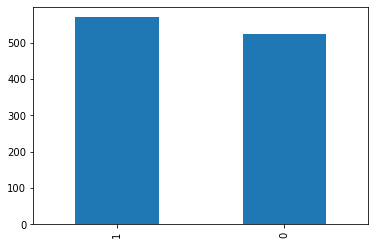

In [6]:
df['label'].value_counts().plot.bar()

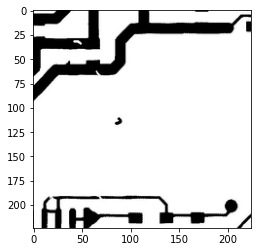

In [7]:
sample=random.choice(filenames)
image = load_img(r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\train\train5/" + sample)
plt.imshow(image)     

In [8]:
base_model=MobileNet(weights='imagenet',include_top=False)
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

C:\Users\Gaurav\anaconda3\envs\py3-TF2.0\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
model = Model(inputs=base_model.input, outputs=preds)

In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [12]:
earlystop = EarlyStopping(patience=10)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,min_lr=0.00001)

In [14]:
callbacks=[earlystop, learning_rate_reduction]

In [15]:
df['label'] = df['label'].replace({0: 'Good', 1: 'Bad'})

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

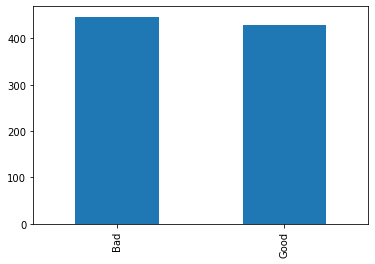

In [17]:
train_df['label'].value_counts().plot.bar()

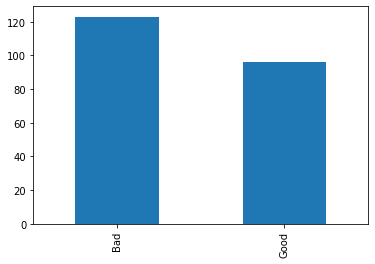

In [18]:
validate_df['label'].value_counts().plot.bar()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [20]:
train_datagen = ImageDataGenerator(rotation_range=15, rescale=1./255,
                                  shear_range=0.1, zoom_range=0.2,
                                  horizontal_flip=True, width_shift_range=0.1,
                                  height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(train_df,
                                                     r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\train\train5/",
                                                     x_col='filename',
                                                     y_col='label',
                                                     target_size=IMAGE_SIZE,
                                                     class_mode='categorical',
                                                     batch_size=batch_size)

Found 876 validated image filenames belonging to 2 classes.


In [21]:
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_dataframe(validate_df,
                                                           r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\train\train5/",
                                                           x_col='filename',
                                                           y_col='label',
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='categorical',
                                                           batch_size=batch_size)

Found 219 validated image filenames belonging to 2 classes.


In [22]:
epochs=3 if FAST_RUN else 20
history = model.fit_generator(train_datagenerator,epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=total_validate//batch_size,
                             steps_per_epoch=total_train//batch_size,
                             callbacks=callbacks)

Epoch 1/20
58/58 [==============================] - 467s 8s/step - loss: 0.6033 - accuracy: 0.7700 - val_loss: 0.5586 - val_accuracy: 0.8905
Epoch 2/20
58/58 [==============================] - 433s 7s/step - loss: 0.2667 - accuracy: 0.9048 - val_loss: 0.3312 - val_accuracy: 0.9286
Epoch 3/20
58/58 [==============================] - 389s 7s/step - loss: 0.2394 - accuracy: 0.9106 - val_loss: 0.4689 - val_accuracy: 0.9286
Epoch 4/20
57/58 [============================>.] - ETA: 6s - loss: 0.1695 - accuracy: 0.9504 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
58/58 [==============================] - 385s 7s/step - loss: 0.1691 - accuracy: 0.9489 - val_loss: 0.2969 - val_accuracy: 0.9143
Epoch 5/20
58/58 [==============================] - 387s 7s/step - loss: 0.1142 - accuracy: 0.9605 - val_loss: 0.0969 - val_accuracy: 0.9571
Epoch 6/20
58/58 [==============================] - 392s 7s/step - loss: 0.1250 - accuracy: 0.9570 - val_loss: 0.1414 - val_accurac

In [23]:
model.save("PCB_defect.h5")
print("Model Saved")

Model Saved


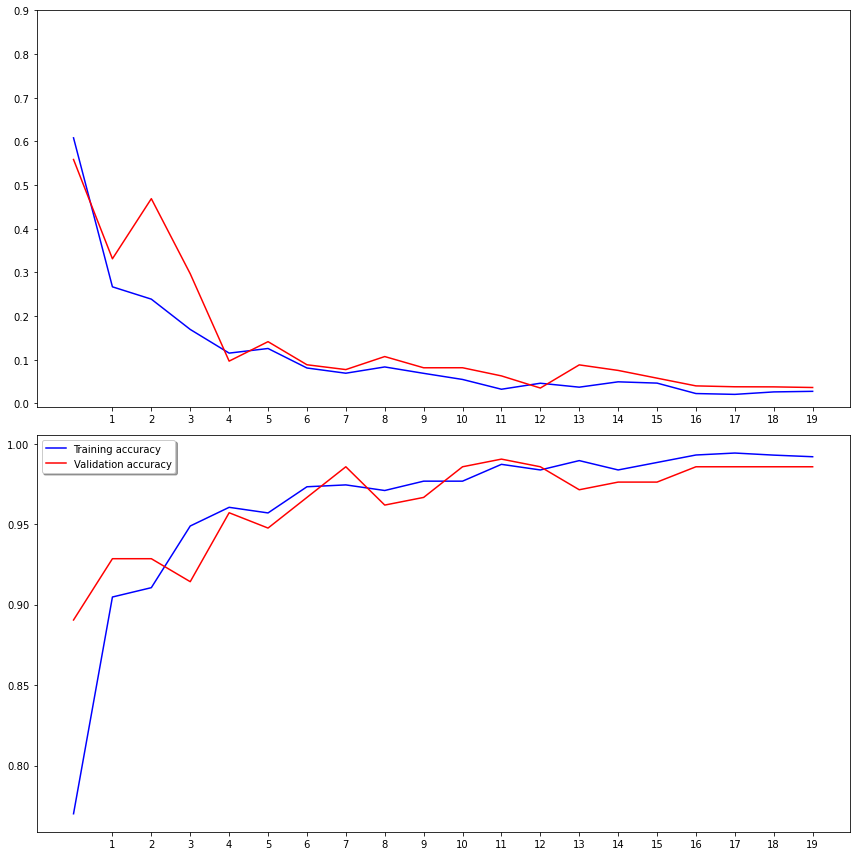

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [27]:
test_filenames=os.listdir(r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\test\test5")
test_df=pd.DataFrame({'filename':test_filenames})
nb_samples = test_df.shape[0]

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator=test_gen.flow_from_dataframe(test_df,
                                           r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\test\test5",
                                           x_col='filename',
                                           y_col=None,
                                           class_mode=None,
                                           target_size=IMAGE_SIZE,
                                           batch_size=batch_size,
                                           shuffle=False)

Found 100 validated image filenames.


In [29]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [30]:
test_df['label'] = np.argmax(predict, axis=-1)

In [33]:
label_map=dict((v,k) for k,v in train_datagenerator.class_indices.items())
test_df['label'] = test_df['label'].replace(label_map)

In [36]:
# test_df['label'].value_counts().plot_bar()

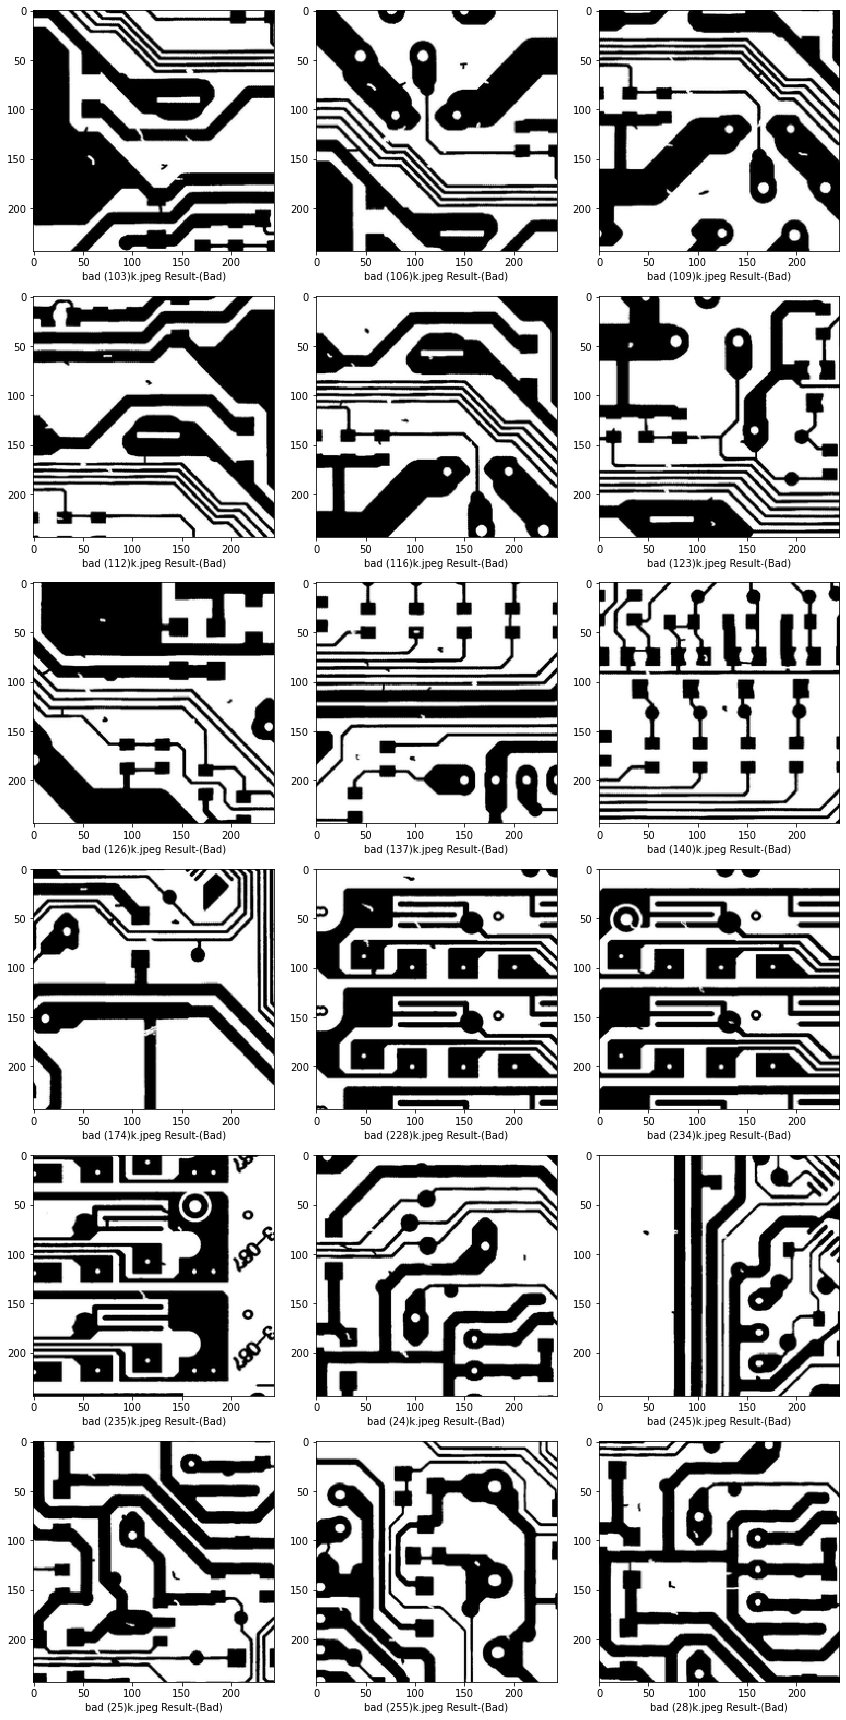

In [38]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']
    img = load_img(r"C:\Users\Gaurav\Desktop\DISK1\Defect_Detection_PCB\Defect-Detection-of-PCB-main\dataset\test\test5/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + (' ') + 'Result-' + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [1]:
model.save_weights("model.h5")

NameError: name 'model' is not defined